#### 변경사항
1. MarkDown 추가
2. 함수 셀 다 위로 올림
3. 처음부터 Raw Data의 한글명 변수를 영문명으로 변환
4. Temp_1hrAfter, Temp_2hrAfter, Temp_3hrAfter 등 변수 생성
5. 전에는 Temp기준으로 모델학습했지만, 추가적으로 Temp_1hrAfter, Temp_2hrAfter 대상도 모델학습
6. Single Point Prediction 그래프 추가

In [1]:
# 참고
#https://deep-deep-deep.tistory.com/60

## Set-up (라이브러리, 파라미터, 함수 설정)

In [2]:
# -----------------------------------------------------------------
# 변경: 라이브러리 추가(warnings, matplotlib, seaborn) ; np.set_printoptions 추가
# 라이브러리 불러오기
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 테이블에 소수 자리수형태로 나타내기
np.set_printoptions(suppress=True)

# GPU 1개만 쓰기
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
# -----------------------------------------------------------------

2022-07-08 06:12:30.385617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 06:12:30.408442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 06:12:30.408916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# 빈폴더 생성
if not os.path.exists('./TIME_SERIES/'):
    os.mkdir('./TIME_SERIES/')
if not os.path.exists('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/')
if not os.path.exists('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/')
    
print(os.getcwd())

/home/alfa_members/hyunjo/tensorflow2


In [4]:
# <---------------- Google Colab에서 돌릴 경우 ----------------> 

# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
dict_args = dict()
dict_args['raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
# dict_args['preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['allVar_raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/allVar_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['allVar_preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/allVar_CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['min_max_file'] = './TIME_SERIES/min_max.csv'
dict_args["window_size"] = 4
dict_args["features"] = ''
dict_args["label"] = ['Temp(°C)','Temp_1hrAfter(°C)','Temp_2hrAfter(°C)','Temp_3hrAfter(°C)','Temp_4hrAfter(°C)','Temp_5hrAfter(°C)',
                      'Temp_6hrAfter(°C)','Temp_7hrAfter(°C)','Temp_8hrAfter(°C)','Temp_9hrAfter(°C)','Temp_10hrAfter(°C)',
                      'Temp_11hrAfter(°C)','Temp_12hrAfter(°C)']
dict_args["index"] = ['AreaCode','AreaName','Timestamp']
dict_args["area"] = "속초"
dict_args["test_size"] = 120
dict_args['model_file'] = ''
dict_args["param_list"] =  {
                            "LSTM": {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            "GRU": 
                                    {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            }


In [6]:
# 한글명 -> 영문명 변경
english_var = {
    '지점' :  'AreaCode',
    '지점명' :  'AreaName',
    '일시' :  'Timestamp',
    '기온(°C)' :  'Temp(°C)',
    '강수량(mm)' :  'WaterFall(mm)',
    '풍속(m/s)' :  'WindSpeed(m/s)',
    '풍향(16방위)' :  'WindDir(16)',
    '습도(%)' :  'Dampness(%)',
    '증기압(hPa)' :  'AirPressure(hPa)',
    '이슬점온도(°C)' :  'DewPointTemp(°C)',
    '현지기압(hPa)' :  'LocalPressure(hPa)',
    '해면기압(hPa)' :  'SeaLevelPressure(hPa)',
    '일조(hr)' :  'SunShine(hr)',
    '일사(MJ/m2)' :  'Radiation(MJ/m2)',
    '적설(cm)' :  'Snow(cm)',
    '3시간신적설(cm)' :  '3hrsSnow(cm)',
    '전운량(10분위)' :  'FullCloud(10)',
    '중하층운량(10분위)' :  'LowMiddleCloud(10)',
    '운형(운형약어)' :  'CloudShape',
    '최저운고(100m )' :  'MinMaxCloudHeight(100m)',
    '기온 QC플래그' :  'TempQCFlag',
    '강수량 QC플래그' :  'WaterFallQCFlag',
    '풍속 QC플래그' :  'WindSpeedQCFlag',
    '풍향 QC플래그' :  'WindDirQCFlag',
    '습도 QC플래그' :  'DampnessQCFlag',
    '현지기압 QC플래그' :  'LocalPressureQCFlag',
    '해면기압 QC플래그' :  'SeaLevelPressureQCFlag',
    '일조 QC플래그' :  'SunShineQCFlag',
    '일사 QC플래그' :  'RadiationQCFlag',
}

print(english_var)

{'지점': 'AreaCode', '지점명': 'AreaName', '일시': 'Timestamp', '기온(°C)': 'Temp(°C)', '강수량(mm)': 'WaterFall(mm)', '풍속(m/s)': 'WindSpeed(m/s)', '풍향(16방위)': 'WindDir(16)', '습도(%)': 'Dampness(%)', '증기압(hPa)': 'AirPressure(hPa)', '이슬점온도(°C)': 'DewPointTemp(°C)', '현지기압(hPa)': 'LocalPressure(hPa)', '해면기압(hPa)': 'SeaLevelPressure(hPa)', '일조(hr)': 'SunShine(hr)', '일사(MJ/m2)': 'Radiation(MJ/m2)', '적설(cm)': 'Snow(cm)', '3시간신적설(cm)': '3hrsSnow(cm)', '전운량(10분위)': 'FullCloud(10)', '중하층운량(10분위)': 'LowMiddleCloud(10)', '운형(운형약어)': 'CloudShape', '최저운고(100m )': 'MinMaxCloudHeight(100m)', '기온 QC플래그': 'TempQCFlag', '강수량 QC플래그': 'WaterFallQCFlag', '풍속 QC플래그': 'WindSpeedQCFlag', '풍향 QC플래그': 'WindDirQCFlag', '습도 QC플래그': 'DampnessQCFlag', '현지기압 QC플래그': 'LocalPressureQCFlag', '해면기압 QC플래그': 'SeaLevelPressureQCFlag', '일조 QC플래그': 'SunShineQCFlag', '일사 QC플래그': 'RadiationQCFlag'}


In [7]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 8

In [8]:
# 변수 데이터 분포도
def draw_graph(df): 
    fig, axes = plt.subplots(4, 4, sharex=False)

    sns.distplot(df['Temp(°C)'], bins=70, kde=False, ax=axes[0,0])
    sns.distplot(df['WaterFall(mm)'], bins=70, kde=False, ax=axes[0,1])
    sns.distplot(df['WindSpeed(m/s)'], bins=70, kde=False, ax=axes[0,2])
    sns.distplot(df['WindDir(16)'], bins=70, kde=False, ax=axes[0,3])
    sns.distplot(df['Dampness(%)'], bins=70, kde=False, ax=axes[1,0])
    sns.distplot(df['AirPressure(hPa)'], bins=70, kde=False, ax=axes[1,1])
    sns.distplot(df['DewPointTemp(°C)'], bins=70, kde=False, ax=axes[1,2])
    sns.distplot(df['LocalPressure(hPa)'], bins=70, kde=False, ax=axes[1,3])
    sns.distplot(df['SeaLevelPressure(hPa)'], bins=70, kde=False, ax=axes[2,0])
    sns.distplot(df['SunShine(hr)'], bins=70, kde=False, ax=axes[2,1])
    sns.distplot(df['Radiation(MJ/m2)'], bins=70, kde=False, ax=axes[2,2])
    sns.distplot(df['Snow(cm)'], bins=70, kde=False, ax=axes[2,3]) 
    sns.distplot(df['3hrsSnow(cm)'], bins=70, kde=False, ax=axes[3,0])
    sns.distplot(df['FullCloud(10)'], bins=70, kde=False, ax=axes[3,1])
    sns.distplot(df['LowMiddleCloud(10)'], bins=70, kde=False, ax=axes[3,2])
    sns.distplot(df['CloudShape'], bins=70, kde=False, ax=axes[3,3])
    
    plt.plot()


def make_preprocessed_file(p_args):

    try: 
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='utf-8') 
    except:
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='euc-kr')

    # display(df)
    # print(df.columns)
    columns = ['AreaCode','AreaName','Timestamp']
    columns.extend(p_args["features"])
    print(columns)

    df = df[columns]
    df = df[df['AreaName'] == p_args["area"]] 
    df.index = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%S')

    df = df[p_args["features"]]
    
    # 변수 Float Type으로 저장 및 Null값 제거 
    df = df.astype('float32')
    df = df.fillna(0)
    print(df.info())
    print(df.isna().sum())
    display(df)
    df.to_csv(p_args['allVar_preprocessed_file'], encoding='utf-8')
    return p_args


def make_dataset_regression(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        # print('feature list: ', np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        # print('label list: ', np.array(label.iloc[i:i+window_size])) 
    return np.array(feature_list), np.array(label_list)


def split_dataset_regression(p_args, scaling_flag=True):
   
    df = pd.read_csv(p_args["allVar_preprocessed_file"])
    # df = df.fillna(0)
    df = df.set_index('Timestamp')
    # df = df.astype(float)

    # 수치 정규화 
    if scaling_flag: 
        print('정규화된 데이터입니다.')
        df_scaled = df.copy()
        
        min_max_df = pd.DataFrame() 
        for col in df_scaled.columns:
            min_ = np.min(df_scaled[col])
            max_ = np.max(df_scaled[col])

            min_max_dict = dict()
            scaled_list = list()
            for x in df_scaled[col]:
                scaled_x = (x - min_) / (max_ - min_)
                scaled_list.append(scaled_x)
            df_scaled[col] = scaled_list   
            
            min_max_dict['VAR'] = col
            min_max_dict['min'] = min_
            min_max_dict['max'] = max_            
                
            min_max_list = []
            min_max_list.append(min_max_dict)
            tmpdf = pd.DataFrame(min_max_list)
            # display(tmpdf)
            min_max_df = pd.concat([min_max_df, tmpdf], axis=0) 
                
        # 중간에 MIN_MAX 파일로 저장 (나중에 원래 수치로 다시 계산할때 필요)
        min_max_df.to_csv(p_args["min_max_file"], index=None, encoding='utf-8')

    else:
        print('정규화가 제외된 데이터입니다.')
        df_scaled = df.copy()
        # display(df_scaled.head(5))
    
    # Train과 Test 분리
    train = df_scaled[:-p_args["test_size"]]
    test = df_scaled[-p_args["test_size"]:]
    print("train: ", train.shape, type(train))
    print("test: ", test.shape, type(test))
    # display(train.head(5))
    # display(test.head(5))
    
    train_feature, train_label = make_dataset_regression(train[p_args["features"]], train[p_args["label"]], window_size = p_args["window_size"])
    print("train_feature: ", train_feature.shape, type(train_feature))
    print("train_label: ", train_label.shape, type(train_label))
    
    # Train에서 Train Set, Valid Set 분리 (검증셋)
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.2)
    
    # ----------------------------------------------------
    # 변경: y_train -> y_train_list (y_train_list에 Temp뿐만 아니라, Temp_1hrAfter, Temp_2hrAfter 등 변수를 함께 묶어서 저장)
    X_train = X_train.astype(float)
    y_train_list = y_train.astype(float)
    X_valid = X_valid.astype(float)
    y_valid_list = y_valid.astype(float)

    print("X_train: ",  X_train.shape, type(X_train))
    print("y_train_list: ",  y_train_list.shape, type(y_train))
    print("X_valid: ",  X_valid.shape, type(X_valid))
    print("y_valid_list: ",  y_valid_list.shape, type(y_valid))
    
    # Test set에서 feature, label 분리
    X_test, y_test = make_dataset_regression(test[p_args["features"]], test[p_args["label"]], window_size = p_args["window_size"])
    y_test_list = y_test
    print("X_test: ", X_test.shape)
    print("y_test_list: ", y_test_list.shape)
    
    print(X_train[0])
    print(y_train[0])

    return train, test, train_feature, train_label, X_train, y_train_list, X_valid, y_valid_list, X_test, y_test_list


def build_LSTM_model(p_args, train_set):
    model = Sequential()
    model.add(LSTM(32, 
              input_shape=(train_set.shape[1], train_set.shape[2]),
              activation='relu',
              return_sequences=False))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    print(model.summary())

    # cp = ModelCheckpoint(p_args['model_file'], save_best_only=True)
    model.compile(loss='mean_squared_error', 
                  optimizer= Adam(learning_rate=p_args["param_list"]["LSTM"]["learning_rate"]), 
                  metrics=['mae'],
                  )
    return model


def build_GRU_model(p_args, train_set):
    model = Sequential()
    model.add(GRU(32, 
              input_shape=(train_set.shape[1], train_set.shape[2]),
              activation='relu',
              return_sequences=False))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    print(model.summary())

    # cp = ModelCheckpoint(p_args['model_file'], save_best_only=True)
    model.compile(loss='mean_squared_error', 
                  optimizer= Adam(learning_rate=p_args["param_list"]["LSTM"]["learning_rate"]), 
                  metrics=['mae'],
                  )
    return model


def reverse_minmax(label, min_, max_):
    result_list = list()
    for element in label:
        new_element = element * (max_ - min_) + min_
        result_list.append(new_element)
    result_array = np.array(result_list)
    return result_array


# 변경: 한글 변수명 -> 영문 변경 함수 추가
def change_col_to_english(df, english_var):
    english_names = list()
        
    for col in df.columns.tolist():
        try:
            english_names.append(english_var.get(col))
        except:
            pass
    df.columns = english_names
    return df
# -----------------------------------------------------------------

## EDA (변수별 분포 그래프 그리기, 필요한 변수 탐색)

Index(['AreaCode', 'AreaName', 'Timestamp', 'Temp(°C)', 'TempQCFlag',
       'WaterFall(mm)', 'WaterFallQCFlag', 'WindSpeed(m/s)', 'WindSpeedQCFlag',
       'WindDir(16)', 'WindDirQCFlag', 'Dampness(%)', 'DampnessQCFlag',
       'AirPressure(hPa)', 'DewPointTemp(°C)', 'LocalPressure(hPa)',
       'LocalPressureQCFlag', 'SeaLevelPressure(hPa)',
       'SeaLevelPressureQCFlag', 'SunShine(hr)', 'SunShineQCFlag',
       'Radiation(MJ/m2)', 'RadiationQCFlag', 'Snow(cm)', '3hrsSnow(cm)',
       'FullCloud(10)', 'LowMiddleCloud(10)', 'CloudShape',
       'MinMaxCloudHeight(100m)'],
      dtype='object')
16
변수별 NULL 값 확인----
AreaCode                     0
AreaName                     0
Timestamp                    0
Temp(°C)                     0
TempQCFlag                 744
WaterFall(mm)              702
WaterFallQCFlag            597
WindSpeed(m/s)               0
WindSpeedQCFlag            744
WindDir(16)                  0
WindDirQCFlag              744
Dampness(%)                  0
Dam

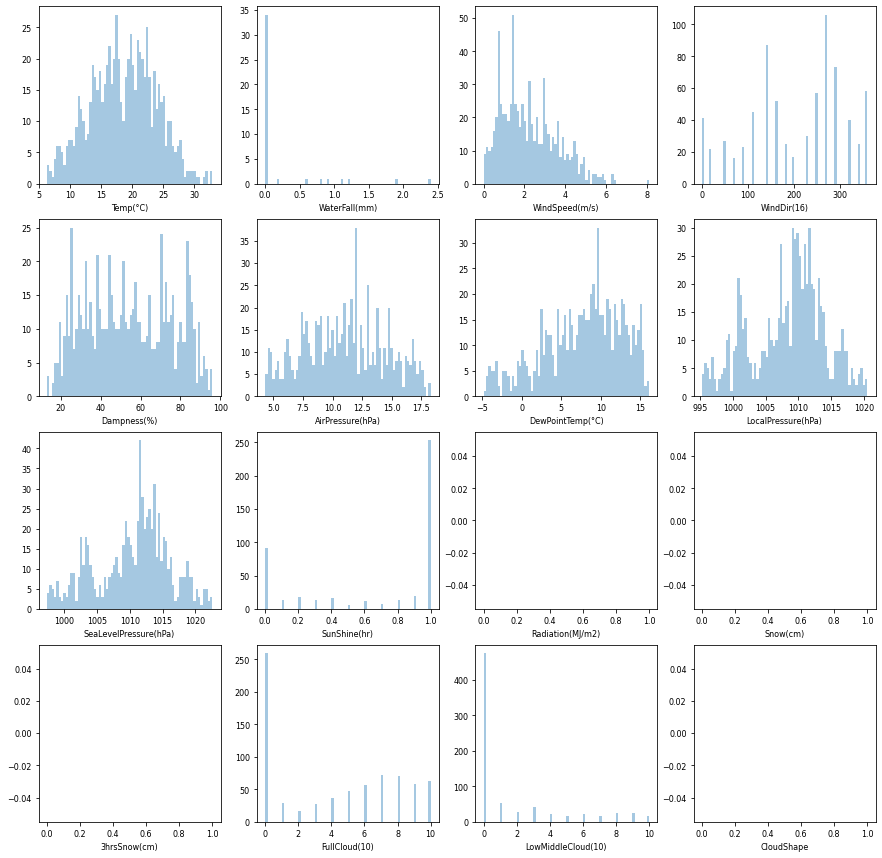

In [9]:
# 파일 읽기
df = pd.read_csv(dict_args['raw_file'], encoding='euc-kr')
# 한글 변수명 영문으로 바꾸기
df = change_col_to_english(df, english_var)
# display(df)
print(df.columns)
df = df[df['AreaName']==dict_args["area"]]


# 변수별 데이터 분포 확인
graph_cols = ['Temp(°C)','WaterFall(mm)','WindSpeed(m/s)','WindDir(16)','Dampness(%)','AirPressure(hPa)','DewPointTemp(°C)',
              'LocalPressure(hPa)','SeaLevelPressure(hPa)','SunShine(hr)','Radiation(MJ/m2)','Snow(cm)','3hrsSnow(cm)',
              'FullCloud(10)','LowMiddleCloud(10)','CloudShape']
print(len(graph_cols))
graph_df = df[graph_cols]
draw_graph(graph_df)

# 변수별 NULL 값 확인 
print("변수별 NULL 값 확인----")
print(df.isna().sum())
print("-"*80)

drop_columns = [
"TempQCFlag",
"WaterFall(mm)",
"WaterFallQCFlag",
"WindSpeedQCFlag",
"WindDir(16)",
"WindDirQCFlag",
"DampnessQCFlag",
"LocalPressureQCFlag",
"SeaLevelPressureQCFlag",
"SunShine(hr)",
"SunShineQCFlag",
"Radiation(MJ/m2)",
"RadiationQCFlag",
"Snow(cm)",
"3hrsSnow(cm)",
"FullCloud(10)",
"LowMiddleCloud(10)",
"CloudShape",
"MinMaxCloudHeight(100m)"
]

# 불필요한 변수 제거 (Flag 변수는 BIT변수라서 제거, NULL값이 많은 변수 제거, 구름과 관련된 변수는 우선 제거)
df = df.drop(drop_columns, axis=1)

# 변경: 1~12 시간 뒤 기온 변수 생성
df['Temp_1hrAfter(°C)'] = df['Temp(°C)'].shift(-1)
df['Temp_2hrAfter(°C)'] = df['Temp(°C)'].shift(-2)
df['Temp_3hrAfter(°C)'] = df['Temp(°C)'].shift(-3)
df['Temp_4hrAfter(°C)'] = df['Temp(°C)'].shift(-4)
df['Temp_5hrAfter(°C)'] = df['Temp(°C)'].shift(-5)
df['Temp_6hrAfter(°C)'] = df['Temp(°C)'].shift(-6)
df['Temp_7hrAfter(°C)'] = df['Temp(°C)'].shift(-7)
df['Temp_8hrAfter(°C)'] = df['Temp(°C)'].shift(-8)
df['Temp_9hrAfter(°C)'] = df['Temp(°C)'].shift(-9)
df['Temp_10hrAfter(°C)'] = df['Temp(°C)'].shift(-10)
df['Temp_11hrAfter(°C)'] = df['Temp(°C)'].shift(-11)
df['Temp_12hrAfter(°C)'] = df['Temp(°C)'].shift(-12)


# 제일 밑 12개 행 제거 (Temp_1hrAfter 등 변수 생성시 Null값 존재)
df = df.head(df.shape[0] - 12)

# 필요한 변수만 선택해서 allVar_Raw File 명으로 저장
df.to_csv(dict_args['allVar_raw_file'], index=None)

# Feature 리스트 저장
column_list = df.columns.tolist()
del column_list[0:3]
dict_args["features"] = column_list
# -----------------------------------------------------------------

## Raw Data 전처리 및 Preprocessed File 생성

In [10]:
make_preprocessed_file(dict_args)

['AreaCode', 'AreaName', 'Timestamp', 'Temp(°C)', 'WindSpeed(m/s)', 'Dampness(%)', 'AirPressure(hPa)', 'DewPointTemp(°C)', 'LocalPressure(hPa)', 'SeaLevelPressure(hPa)', 'Temp_1hrAfter(°C)', 'Temp_2hrAfter(°C)', 'Temp_3hrAfter(°C)', 'Temp_4hrAfter(°C)', 'Temp_5hrAfter(°C)', 'Temp_6hrAfter(°C)', 'Temp_7hrAfter(°C)', 'Temp_8hrAfter(°C)', 'Temp_9hrAfter(°C)', 'Temp_10hrAfter(°C)', 'Temp_11hrAfter(°C)', 'Temp_12hrAfter(°C)']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-05-01 01:00:00 to 2022-05-31 12:00:00
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temp(°C)               732 non-null    float32
 1   WindSpeed(m/s)         732 non-null    float32
 2   Dampness(%)            732 non-null    float32
 3   AirPressure(hPa)       732 non-null    float32
 4   DewPointTemp(°C)       732 non-null    float32
 5   LocalPressure(hPa)     732 non-null    float32
 6   SeaLevelPres

,Temp(°C),WindSpeed(m/s),Dampness(%),AirPressure(hPa),DewPointTemp(°C),LocalPressure(hPa),SeaLevelPressure(hPa),Temp_1hrAfter(°C),Temp_2hrAfter(°C),Temp_3hrAfter(°C),Temp_4hrAfter(°C),Temp_5hrAfter(°C),Temp_6hrAfter(°C),Temp_7hrAfter(°C),Temp_8hrAfter(°C),Temp_9hrAfter(°C),Temp_10hrAfter(°C),Temp_11hrAfter(°C),Temp_12hrAfter(°C)
Timestamp,,,,,,,,,,,,,,,,,,,
2022-05-01 01:00:00,11.400000,1.7,46.0,6.200000,0.1,1011.700012,1013.799988,11.900000,10.700000,10.5,10.2,10.200000,13.000000,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000
2022-05-01 02:00:00,11.900000,3.4,38.0,5.300000,-1.9,1011.099976,1013.200012,10.700000,10.500000,10.2,10.2,13.000000,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999
2022-05-01 03:00:00,10.700000,2.7,46.0,5.900000,-0.4,1010.900024,1013.000000,10.500000,10.200000,10.2,13.0,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001
2022-05-01 04:00:00,10.500000,1.9,44.0,5.600000,-1.2,1010.700012,1012.799988,10.200000,10.200000,13.0,14.1,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001,16.000000
2022-05-01 05:00:00,10.200000,1.2,40.0,5.000000,-2.8,1010.000000,1012.099976,10.200000,13.000000,14.1,14.7,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001,16.000000,13.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 08:00:00,22.400000,3.6,32.0,8.600000,4.8,1004.099976,1006.099976,24.299999,21.700001,22.0,20.6,20.500000,21.600000,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999
2022-05-31 09:00:00,24.299999,2.9,28.0,8.500000,4.6,1004.200012,1006.200012,21.700001,22.000000,20.6,20.5,21.600000,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999,22.799999
2022-05-31 10:00:00,21.700001,2.0,63.0,16.299999,14.3,1004.700012,1006.700012,22.000000,20.600000,20.5,21.6,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999,22.799999,22.700001


{'raw_file': './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv',
 'allVar_raw_file': './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/allVar_WEATHER_ASOS_2205.csv',
 'allVar_preprocessed_file': './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/allVar_CLEAN_WEATHER_ASOS_2205.csv',
 'min_max_file': './TIME_SERIES/min_max.csv',
 'window_size': 4,
 'features': ['Temp(°C)',
  'WindSpeed(m/s)',
  'Dampness(%)',
  'AirPressure(hPa)',
  'DewPointTemp(°C)',
  'LocalPressure(hPa)',
  'SeaLevelPressure(hPa)',
  'Temp_1hrAfter(°C)',
  'Temp_2hrAfter(°C)',
  'Temp_3hrAfter(°C)',
  'Temp_4hrAfter(°C)',
  'Temp_5hrAfter(°C)',
  'Temp_6hrAfter(°C)',
  'Temp_7hrAfter(°C)',
  'Temp_8hrAfter(°C)',
  'Temp_9hrAfter(°C)',
  'Temp_10hrAfter(°C)',
  'Temp_11hrAfter(°C)',
  'Temp_12hrAfter(°C)'],
 'label': ['Temp(°C)',
  'Temp_1hrAfter(°C)',
  'Temp_2hrAfter(°C)',
  'Temp_3hrAfter(°C)',
  'Temp_4hrAfter(°C)',
  'Temp_5hrAfter(°C)',
  'Temp_6hrAfter(°C)',
  'Temp_7hrAfter(°C)',
  'Temp_8hrAfter(°C)',
 

## Train Set, Valid Set, Test Set 생성

In [11]:
train, test, train_feature, train_label, X_train, y_train_list, X_valid, y_valid_list, X_test, y_test_list = split_dataset_regression(dict_args, scaling_flag=True)

정규화된 데이터입니다.
train:  (612, 19) <class 'pandas.core.frame.DataFrame'>
test:  (120, 19) <class 'pandas.core.frame.DataFrame'>
train_feature:  (608, 4, 19) <class 'numpy.ndarray'>
train_label:  (608, 13) <class 'numpy.ndarray'>
X_train:  (486, 4, 19) <class 'numpy.ndarray'>
y_train_list:  (486, 13) <class 'numpy.ndarray'>
X_valid:  (122, 4, 19) <class 'numpy.ndarray'>
y_valid_list:  (122, 13) <class 'numpy.ndarray'>
X_test:  (116, 4, 19)
y_test_list:  (116, 13)
[[0.18726592 0.07407407 0.8313253  0.47142857 0.62200957 0.47619048
  0.47826087 0.15730337 0.1011236  0.05992509 0.05243446 0.05243446
  0.13108614 0.19475655 0.17602996 0.17602996 0.31460674 0.4082397
  0.45318352]
 [0.15730337 0.07407407 0.8313253  0.42857143 0.58373206 0.48015873
  0.48221344 0.1011236  0.05992509 0.05243446 0.05243446 0.13108614
  0.19475655 0.17602996 0.17602996 0.31460674 0.4082397  0.45318352
  0.49438202]
 [0.1011236  0.07407407 0.85542169 0.37142857 0.53110048 0.46031746
  0.46245059 0.05992509 0.05243446

## 모델 학습하기 (1시간 뒤 온도를 Label로 고정해서 학습; 예시: Model 4) 

In [12]:
# 변경: Model 4 추가 
# 변경: 전에는 y_train/y_valid를 바로 사용했지만, 지금은 y_train_list/y_valid_list에서 학습대상이 되는 변수값을 y_train/y_valid로 저장해야됨
# 변경: 저장할 Model File 이름 변경
# 1 Point 뒤 예측

model_name = "LSTM"

y_train_name = dict_args['label'][1]  # Temp_1hrAfter(°C)

# y_train_list, y_valid_list에서 Temp_1hrAfter(°C) 데이터만 가져와서 y_train, y_valid 생성 
y_train = list()
for i in range(y_train_list.shape[0]):
    y_train.append(y_train_list[i, 1])   # 리스트에서 두번째 열만 가져오기 ; y_train_list[i, 1] -> Temp_1hrAfter(°C)
y_train = np.array(y_train)
# print(y_train)
# print(y_train.shape)

y_valid = list()
for i in range(y_valid_list.shape[0]):
    y_valid.append(y_valid_list[i, 1])   # 리스트에서 두번째 열만 가져오기 ; y_valid_list[i, 1] -> Temp_1hrAfter(°C) 
y_valid = np.array(y_valid)
# print(y_valid)

dict_args['model_file'] = './TIME_SERIES/' + 'MODEL4' + '_' + model_name + '_VAR_' + str(len(dict_args['features'])) + '_' + y_train_name 

model4 = build_LSTM_model(dict_args, X_train)


epochs = dict_args["param_list"][model_name]["epochs"]
batch_size = dict_args["param_list"][model_name]["batch_size"]

model4.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
           epochs=epochs, 
           batch_size=batch_size,
           callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6656      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


2022-07-08 06:12:32.688624: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 06:12:32.689168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 06:12:32.689690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 06:12:32.690178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

None
Epoch 1/60


2022-07-08 06:12:34.525198: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/10 [==>...........................] - ETA: 12s - loss: 0.1722 - mae: 0.3709

2022-07-08 06:12:35.253432: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 2s 117ms/step - loss: 0.0995 - mae: 0.2593 - val_loss: 0.0450 - val_mae: 0.1785
Epoch 2/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0361 - mae: 0.1640INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 103ms/step - loss: 0.0270 - mae: 0.1386 - val_loss: 0.0178 - val_mae: 0.1089
Epoch 3/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0209 - mae: 0.1227INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0186 - mae: 0.1092 - val_loss: 0.0169 - val_mae: 0.1041
Epoch 4/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0163 - mae: 0.0974INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0141 - mae: 0.0938 - val_loss: 0.0102 - val_mae: 0.0814
Epoch 5/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0129 - mae: 0.0882INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 110ms/step - loss: 0.0092 - mae: 0.0772 - val_loss: 0.0071 - val_mae: 0.0675
Epoch 6/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0526INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0063 - mae: 0.0624 - val_loss: 0.0049 - val_mae: 0.0543
Epoch 7/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0041 - mae: 0.0509INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0046 - mae: 0.0528 - val_loss: 0.0036 - val_mae: 0.0464
Epoch 8/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0041 - mae: 0.0459INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0035 - mae: 0.0454 - val_loss: 0.0028 - val_mae: 0.0410
Epoch 9/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0033 - mae: 0.0453INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0028 - mae: 0.0400 - val_loss: 0.0024 - val_mae: 0.0374
Epoch 10/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0021 - mae: 0.0329INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 11/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0026 - mae: 0.0411INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 113ms/step - loss: 0.0020 - mae: 0.0344 - val_loss: 0.0019 - val_mae: 0.0330
Epoch 12/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0025 - mae: 0.0370INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0018 - mae: 0.0321 - val_loss: 0.0018 - val_mae: 0.0317
Epoch 13/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0019 - mae: 0.0344INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 14/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0246INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 110ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 0.0015 - val_mae: 0.0289
Epoch 15/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0019 - mae: 0.0327INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 16/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0266INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 17/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0265INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0012 - mae: 0.0263 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 18/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.5593e-04 - mae: 0.0244INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0013 - val_mae: 0.0270
Epoch 19/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0015 - mae: 0.0280INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 20/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.9345e-04 - mae: 0.0212INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 113ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 21/60
10/10 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 22/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.6899e-04 - mae: 0.0220INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 23/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0252INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 24/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.2435e-04 - mae: 0.0245INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 107ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 25/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0227INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 26/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0243INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 27/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0269INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 28/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0259INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 96ms/step - loss: 9.6976e-04 - mae: 0.0232 - val_loss: 0.0011 - val_mae: 0.0246
Epoch 29/60
10/10 [==============================] - 0s 5ms/step - loss: 9.5012e-04 - mae: 0.0231 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 30/60
10/10 [==============================] - 0s 5ms/step - loss: 9.4585e-04 - mae: 0.0229 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 31/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0250INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 106ms/step - loss: 9.3628e-04 - mae: 0.0230 - val_loss: 0.0010 - val_mae: 0.0246
Epoch 32/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.4296e-04 - mae: 0.0177INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 9.0638e-04 - mae: 0.0224 - val_loss: 9.9240e-04 - val_mae: 0.0241
Epoch 33/60
10/10 [==============================] - 0s 5ms/step - loss: 8.9750e-04 - mae: 0.0224 - val_loss: 9.9549e-04 - val_mae: 0.0241
Epoch 34/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.2086e-04 - mae: 0.0211INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 8.8228e-04 - mae: 0.0221 - val_loss: 9.5965e-04 - val_mae: 0.0235
Epoch 35/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.3479e-04 - mae: 0.0231INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 115ms/step - loss: 8.6337e-04 - mae: 0.0218 - val_loss: 9.3366e-04 - val_mae: 0.0233
Epoch 36/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.0864e-04 - mae: 0.0190INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 8.6830e-04 - mae: 0.0218 - val_loss: 9.2949e-04 - val_mae: 0.0233
Epoch 37/60
10/10 [==============================] - 0s 5ms/step - loss: 8.4005e-04 - mae: 0.0217 - val_loss: 9.4012e-04 - val_mae: 0.0234
Epoch 38/60
10/10 [==============================] - 0s 5ms/step - loss: 8.2396e-04 - mae: 0.0212 - val_loss: 9.3220e-04 - val_mae: 0.0235
Epoch 39/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.8768e-04 - mae: 0.0224INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 8.4676e-04 - mae: 0.0216 - val_loss: 8.7968e-04 - val_mae: 0.0227
Epoch 40/60
10/10 [==============================] - 0s 5ms/step - loss: 8.5505e-04 - mae: 0.0218 - val_loss: 9.0222e-04 - val_mae: 0.0231
Epoch 41/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.4176e-04 - mae: 0.0204INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 7.8958e-04 - mae: 0.0208 - val_loss: 8.5762e-04 - val_mae: 0.0224
Epoch 42/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.1187e-04 - mae: 0.0181INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 109ms/step - loss: 7.7615e-04 - mae: 0.0206 - val_loss: 8.5480e-04 - val_mae: 0.0223
Epoch 43/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.6281e-04 - mae: 0.0217INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 7.6524e-04 - mae: 0.0204 - val_loss: 8.3123e-04 - val_mae: 0.0220
Epoch 44/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.4813e-04 - mae: 0.0242INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 106ms/step - loss: 7.5631e-04 - mae: 0.0203 - val_loss: 8.1799e-04 - val_mae: 0.0219
Epoch 45/60
10/10 [==============================] - 0s 5ms/step - loss: 7.4390e-04 - mae: 0.0201 - val_loss: 8.2753e-04 - val_mae: 0.0221
Epoch 46/60
 1/10 [==>...........................] - ETA: 0s - loss: 4.5662e-04 - mae: 0.0155INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 7.3939e-04 - mae: 0.0199 - val_loss: 8.1216e-04 - val_mae: 0.0217
Epoch 47/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.3405e-04 - mae: 0.0169INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 7.5005e-04 - mae: 0.0204 - val_loss: 7.8412e-04 - val_mae: 0.0215
Epoch 48/60
10/10 [==============================] - 0s 5ms/step - loss: 7.2976e-04 - mae: 0.0198 - val_loss: 8.1915e-04 - val_mae: 0.0221
Epoch 49/60
 1/10 [==>...........................] - ETA: 0s - loss: 5.8198e-04 - mae: 0.0186INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 114ms/step - loss: 7.2231e-04 - mae: 0.0197 - val_loss: 7.6608e-04 - val_mae: 0.0212
Epoch 50/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.2138e-04 - mae: 0.0226INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 99ms/step - loss: 6.9880e-04 - mae: 0.0195 - val_loss: 7.4678e-04 - val_mae: 0.0209
Epoch 51/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.2857e-04 - mae: 0.0195INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 6.8673e-04 - mae: 0.0191 - val_loss: 7.4596e-04 - val_mae: 0.0209
Epoch 52/60
10/10 [==============================] - 0s 6ms/step - loss: 7.3048e-04 - mae: 0.0200 - val_loss: 8.5451e-04 - val_mae: 0.0224
Epoch 53/60
10/10 [==============================] - 0s 5ms/step - loss: 7.5645e-04 - mae: 0.0204 - val_loss: 9.6863e-04 - val_mae: 0.0241
Epoch 54/60
10/10 [==============================] - 0s 5ms/step - loss: 7.9862e-04 - mae: 0.0214 - val_loss: 8.3506e-04 - val_mae: 0.0222
Epoch 55/60
10/10 [==============================] - 0s 5ms/step - loss: 7.4421e-04 - mae: 0.0203 - val_loss: 7.4633e-04 - val_mae: 0.0210
Epoch 56/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.6505e-04 - mae: 0.0234INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 108ms/step - loss: 6.5622e-04 - mae: 0.0187 - val_loss: 7.1663e-04 - val_mae: 0.0205
Epoch 57/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0248INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 6.5501e-04 - mae: 0.0187 - val_loss: 6.9522e-04 - val_mae: 0.0202
Epoch 58/60
10/10 [==============================] - 0s 5ms/step - loss: 6.4165e-04 - mae: 0.0185 - val_loss: 7.0491e-04 - val_mae: 0.0202
Epoch 59/60
10/10 [==============================] - 0s 5ms/step - loss: 6.3370e-04 - mae: 0.0184 - val_loss: 6.9577e-04 - val_mae: 0.0200
Epoch 60/60
 1/10 [==>...........................] - ETA: 0s - loss: 3.9942e-04 - mae: 0.0143INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 6.4318e-04 - mae: 0.0186 - val_loss: 6.7159e-04 - val_mae: 0.0199


In [13]:
# 변경: 전에는 y_test를 바로 사용했지만, 지금은 y_test_list에서 학습대상이 되는 변수값을 y_test로 저장해야됨
from tensorflow.keras.models import load_model

# y_test_list에서 Temp_1hrAfter(°C) 데이터만 가져와서 y_test 생성

y_test = list()
for i in range(y_test_list.shape[0]):
    y_test.append(y_test_list[i, 1])     # 리스트에서 두번째 열만 가져오기 ; y_test_list[i, 1] -> Temp_1hrAfter(°C)
y_test = np.array(y_test)

print('-'*30, dict_args['model_file'].split('/')[-1], ' 예측 결과입니다', '-'*30)
model4 = load_model(dict_args['model_file'])
model4.evaluate(X_test, y_test)
#---------------------------------------------------------------#

------------------------------ MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)  예측 결과입니다 ------------------------------


4/4 [==============================] - 0s 2ms/step - loss: 6.5289e-04 - mae: 0.0187


[0.0006528914091177285, 0.018660377711057663]

,Test Predictions,Actuals,Test Predictions_original_values,Actuals_original_values
0,0.631108,0.662921,23.050596,23.9
1,0.590491,0.610487,21.966103,22.5
2,0.552501,0.561798,20.951766,21.2
3,0.524755,0.558052,20.210954,21.1
4,0.496706,0.516854,19.462048,20.0
...,...,...,...,...
111,0.618301,0.677903,22.708626,24.3
112,0.601046,0.580524,22.247929,21.7
113,0.572922,0.591760,21.497025,22.0
114,0.562765,0.539326,21.225816,20.6


Text(0.5, 0.98, 'Trend Prediction')

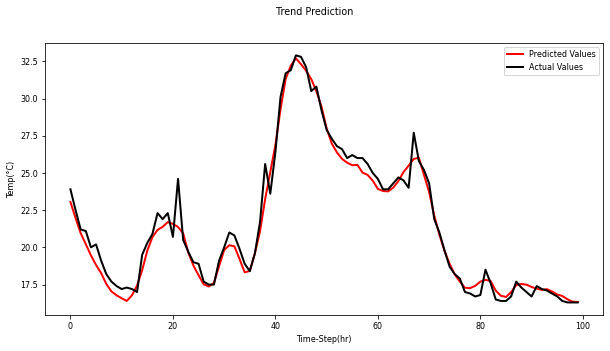

In [14]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2

train_predictions = model4.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test})
# display(train_results)

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_1hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

    for label_col in train_results.columns:
        label = np.array(train_results[label_col])
        result_array = reverse_minmax(label, min_, max_)
        train_results[label_col + '_original_values'] = result_array
display(train_results)

plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")
# 변경: time range 바꿈
plt.plot(train_results['Test Predictions_original_values'][:100], 'r', label='Predicted Values')
plt.plot(train_results['Actuals_original_values'][:100], 'k', label='Actual Values')
plt.legend()
plt.suptitle("Trend Prediction")
#---------------------------------------------------------------#

predicted_future_point:  23.050595957040784
true_future_point:  22.5
history_values:  [23.6 24.7 24.9 24.8]



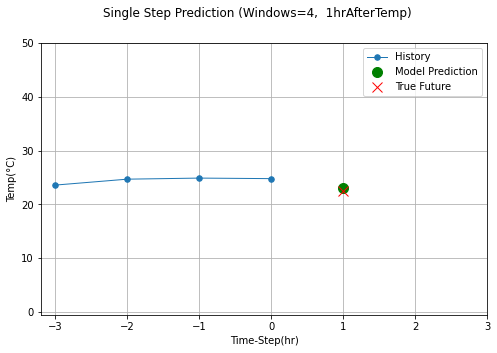

In [15]:
# 변경 Single Point Graph 코드 추가
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


future_time_step = 1
predicted_future_point = model4.predict(X_test).flatten()[0]
# y_train도 1시간 뒤에 값이므로 y_test도 1시간 뒤 값으로 맞춰주기
true_future_point = y_test[0 + future_time_step]

history_values = X_test[0][:, 7]    # X_test의 8 번째 열 (Temp_1hrAfter(°C))에 대한 4 times window 만들기   
history_time_steps = list(range(-len(history_values)+1, 1))

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_1hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

# min-max scaling된 값을 원래값으로 되돌리기
predicted_future_point = predicted_future_point * (max_ - min_) + min_
true_future_point = true_future_point * (max_ - min_) + min_
history_values = list(map(lambda x: (x * (max_ - min_) + min_), history_values))
history_values = np.array(history_values)

print("predicted_future_point: ", predicted_future_point)
print("true_future_point: ", true_future_point)
print("history_values: ", history_values)
print()

labels = ["History", "True Future", "Model Prediction"]
marker = [".-", "rx", "go"]

plt.xlim([-3.2, 3])
plt.ylim([-0.5, 50])
plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")

# 과거 기온 값 (windows=4)
plt.plot(history_time_steps, history_values, marker[0], markersize=11, label=labels[0])
# 학습된 모델로 예측된 1시간후 기온
plt.plot(future_time_step, predicted_future_point, marker[2], markersize=10, label=labels[2])
# 실제 기온
plt.plot(future_time_step, true_future_point, marker[1], markersize=10, label=labels[1]) 

plt.legend()
plt.suptitle("Single Step Prediction (Windows=4,  1hrAfterTemp)")
plt.show()


## 모델 학습하기 (2시간 뒤 온도를 Label로 고정해서 학습; 예시: Model 5) 

In [16]:
# 변경: Model 5 추가 
# 변경: 전에는 y_train/y_valid를 바로 사용했지만, 지금은 y_train_list/y_valid_list에서 학습대상이 되는 변수값을 y_train/y_valid로 저장해야됨
# 변경: 저장할 Model File 이름 변경
# 2 Point 뒤 예측

model_name = "LSTM"

y_train_name = dict_args['label'][2]  # Temp_2hrAfter(°C)

# y_train_list, y_valid_list에서 Temp_2hrAfter(°C) 데이터만 가져와서 y_train, y_valid 생성 
y_train = list()
for i in range(y_train_list.shape[0]):
    y_train.append(y_train_list[i, 2])   # 리스트에서 두번째 열만 가져오기 ; y_train_list[i, 2] -> Temp_2hrAfter(°C)
y_train = np.array(y_train)
# print(y_train)
# print(y_train.shape)

y_valid = list()
for i in range(y_valid_list.shape[0]):
    y_valid.append(y_valid_list[i, 2])   # 리스트에서 두번째 열만 가져오기 ; y_valid_list[i, 2] -> Temp_2hrAfter(°C) 
y_valid = np.array(y_valid)
# print(y_valid)

dict_args['model_file'] = './TIME_SERIES/' + 'MODEL5' + '_' + model_name + '_VAR_' + str(len(dict_args['features'])) + '_' + y_train_name 

model5 = build_LSTM_model(dict_args, X_train)


epochs = dict_args["param_list"][model_name]["epochs"]
batch_size = dict_args["param_list"][model_name]["batch_size"]

model5.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
           epochs=epochs, 
           batch_size=batch_size,
           callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                6656      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
 1/10 [==>...........................] - ETA: 5s - loss: 0.0514 - mae: 0.1965INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 2s 110ms/step - loss: 0.0207 - mae: 0.1141 - val_loss: 0.0116 - val_mae: 0.0915
Epoch 2/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0108 - mae: 0.0866INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0117 - mae: 0.0898 - val_loss: 0.0097 - val_mae: 0.0831
Epoch 3/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0079 - mae: 0.0728 - val_loss: 0.0104 - val_mae: 0.0817
Epoch 4/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0059 - mae: 0.0617INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 99ms/step - loss: 0.0070 - mae: 0.0673 - val_loss: 0.0077 - val_mae: 0.0716
Epoch 5/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0607INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0060 - mae: 0.0633 - val_loss: 0.0068 - val_mae: 0.0672
Epoch 6/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0039 - mae: 0.0496INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0054 - mae: 0.0595 - val_loss: 0.0066 - val_mae: 0.0656
Epoch 7/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0052 - mae: 0.0606INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0050 - mae: 0.0573 - val_loss: 0.0059 - val_mae: 0.0614
Epoch 8/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0036 - mae: 0.0488INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0047 - mae: 0.0557 - val_loss: 0.0055 - val_mae: 0.0591
Epoch 9/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0546INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0044 - mae: 0.0541 - val_loss: 0.0052 - val_mae: 0.0570
Epoch 10/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0570INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0042 - mae: 0.0529 - val_loss: 0.0048 - val_mae: 0.0542
Epoch 11/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0039 - mae: 0.0481INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0038 - mae: 0.0505 - val_loss: 0.0041 - val_mae: 0.0494
Epoch 12/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0036 - mae: 0.0489INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0036 - mae: 0.0483 - val_loss: 0.0038 - val_mae: 0.0462
Epoch 13/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0032 - mae: 0.0413INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 114ms/step - loss: 0.0033 - mae: 0.0466 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 14/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0032 - mae: 0.0463INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 99ms/step - loss: 0.0031 - mae: 0.0447 - val_loss: 0.0034 - val_mae: 0.0435
Epoch 15/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0475INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0029 - mae: 0.0439 - val_loss: 0.0032 - val_mae: 0.0424
Epoch 16/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0424 - val_loss: 0.0033 - val_mae: 0.0442
Epoch 17/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0023 - mae: 0.0388INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0026 - mae: 0.0406 - val_loss: 0.0029 - val_mae: 0.0399
Epoch 18/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0022 - mae: 0.0391INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0025 - mae: 0.0394 - val_loss: 0.0029 - val_mae: 0.0407
Epoch 19/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0021 - mae: 0.0400INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0023 - mae: 0.0382 - val_loss: 0.0027 - val_mae: 0.0382
Epoch 20/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0016 - mae: 0.0317INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 114ms/step - loss: 0.0022 - mae: 0.0370 - val_loss: 0.0025 - val_mae: 0.0371
Epoch 21/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0027 - mae: 0.0406INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0021 - mae: 0.0357 - val_loss: 0.0023 - val_mae: 0.0358
Epoch 22/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0019 - mae: 0.0309INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0020 - mae: 0.0343 - val_loss: 0.0022 - val_mae: 0.0346
Epoch 23/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0017 - mae: 0.0327INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0020 - val_mae: 0.0330
Epoch 24/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0023 - mae: 0.0389INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 113ms/step - loss: 0.0017 - mae: 0.0317 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 25/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0020 - mae: 0.0321INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0016 - mae: 0.0304 - val_loss: 0.0017 - val_mae: 0.0305
Epoch 26/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0013 - mae: 0.0278INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0016 - mae: 0.0308 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 27/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0018 - mae: 0.0314INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 110ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 28/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0021 - mae: 0.0344INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 0.0013 - val_mae: 0.0273
Epoch 29/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0016 - mae: 0.0281INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 30/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0013 - val_mae: 0.0274
Epoch 31/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0259INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 114ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 32/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0012 - val_mae: 0.0272
Epoch 33/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0251INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 34/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0269INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 35/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0253INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0010 - val_mae: 0.0246
Epoch 36/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0279INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 9.1586e-04 - val_mae: 0.0229
Epoch 37/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0240INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 9.4462e-04 - mae: 0.0230 - val_loss: 8.5859e-04 - val_mae: 0.0223
Epoch 38/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0249INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 9.1121e-04 - mae: 0.0225 - val_loss: 8.3209e-04 - val_mae: 0.0217
Epoch 39/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.1435e-04 - mae: 0.0218INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 137ms/step - loss: 9.1231e-04 - mae: 0.0225 - val_loss: 7.9576e-04 - val_mae: 0.0214
Epoch 40/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.4870e-04 - mae: 0.0218INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 104ms/step - loss: 8.7893e-04 - mae: 0.0221 - val_loss: 7.8564e-04 - val_mae: 0.0210
Epoch 41/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.8957e-04 - mae: 0.0241INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 103ms/step - loss: 8.7589e-04 - mae: 0.0219 - val_loss: 7.5860e-04 - val_mae: 0.0206
Epoch 42/60
10/10 [==============================] - 0s 5ms/step - loss: 8.7121e-04 - mae: 0.0221 - val_loss: 7.7427e-04 - val_mae: 0.0211
Epoch 43/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.5760e-04 - mae: 0.0198INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 110ms/step - loss: 9.4447e-04 - mae: 0.0231 - val_loss: 7.1598e-04 - val_mae: 0.0201
Epoch 44/60
 1/10 [==>...........................] - ETA: 0s - loss: 9.5000e-04 - mae: 0.0244INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 8.4917e-04 - mae: 0.0215 - val_loss: 7.0192e-04 - val_mae: 0.0198
Epoch 45/60
 1/10 [==>...........................] - ETA: 0s - loss: 5.8457e-04 - mae: 0.0180INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 93ms/step - loss: 7.7627e-04 - mae: 0.0206 - val_loss: 6.8448e-04 - val_mae: 0.0195
Epoch 46/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.9610e-04 - mae: 0.0210INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 110ms/step - loss: 7.7674e-04 - mae: 0.0205 - val_loss: 6.7959e-04 - val_mae: 0.0194
Epoch 47/60
10/10 [==============================] - 0s 5ms/step - loss: 7.8298e-04 - mae: 0.0208 - val_loss: 8.1544e-04 - val_mae: 0.0220
Epoch 48/60
10/10 [==============================] - 0s 5ms/step - loss: 8.2442e-04 - mae: 0.0219 - val_loss: 7.1825e-04 - val_mae: 0.0204
Epoch 49/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.5782e-04 - mae: 0.0223INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 95ms/step - loss: 7.4515e-04 - mae: 0.0201 - val_loss: 6.3040e-04 - val_mae: 0.0187
Epoch 50/60
10/10 [==============================] - 0s 5ms/step - loss: 7.2848e-04 - mae: 0.0201 - val_loss: 6.4104e-04 - val_mae: 0.0189
Epoch 51/60
 1/10 [==>...........................] - ETA: 0s - loss: 7.8651e-04 - mae: 0.0215INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 97ms/step - loss: 7.1503e-04 - mae: 0.0198 - val_loss: 6.1672e-04 - val_mae: 0.0186
Epoch 52/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.2457e-04 - mae: 0.0223INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 98ms/step - loss: 7.1627e-04 - mae: 0.0198 - val_loss: 6.1548e-04 - val_mae: 0.0186
Epoch 53/60
 1/10 [==>...........................] - ETA: 0s - loss: 8.1609e-04 - mae: 0.0209INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 113ms/step - loss: 7.1267e-04 - mae: 0.0200 - val_loss: 5.9497e-04 - val_mae: 0.0182
Epoch 54/60
10/10 [==============================] - 0s 5ms/step - loss: 6.7752e-04 - mae: 0.0191 - val_loss: 5.9781e-04 - val_mae: 0.0183
Epoch 55/60
 1/10 [==>...........................] - ETA: 0s - loss: 5.0537e-04 - mae: 0.0172INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 6.7574e-04 - mae: 0.0191 - val_loss: 5.9213e-04 - val_mae: 0.0183
Epoch 56/60
10/10 [==============================] - 0s 5ms/step - loss: 6.6396e-04 - mae: 0.0191 - val_loss: 5.9379e-04 - val_mae: 0.0183
Epoch 57/60
 1/10 [==>...........................] - ETA: 0s - loss: 6.3510e-04 - mae: 0.0191INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 94ms/step - loss: 6.7200e-04 - mae: 0.0192 - val_loss: 5.7146e-04 - val_mae: 0.0179
Epoch 58/60
10/10 [==============================] - 0s 5ms/step - loss: 7.0487e-04 - mae: 0.0200 - val_loss: 5.8488e-04 - val_mae: 0.0182
Epoch 59/60
10/10 [==============================] - 0s 5ms/step - loss: 6.7685e-04 - mae: 0.0194 - val_loss: 6.3688e-04 - val_mae: 0.0191
Epoch 60/60
 1/10 [==>...........................] - ETA: 0s - loss: 4.9526e-04 - mae: 0.0179INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)/assets


10/10 [==============================] - 1s 109ms/step - loss: 6.5670e-04 - mae: 0.0191 - val_loss: 5.4652e-04 - val_mae: 0.0176


In [17]:
# 변경: 전에는 y_test를 바로 사용했지만, 지금은 y_test_list에서 학습대상이 되는 변수값을 y_test로 저장해야됨
from tensorflow.keras.models import load_model

# y_test_list에서 Temp_2hrAfter(°C) 데이터만 가져와서 y_test 생성

y_test = list()
for i in range(y_test_list.shape[0]):
    y_test.append(y_test_list[i, 2])     # 리스트에서 두번째 열만 가져오기 ; y_test_list[i, 2] -> Temp_2hrAfter(°C)
y_test = np.array(y_test)

print('-'*30, dict_args['model_file'].split('/')[-1], ' 예측 결과입니다', '-'*30)
model5 = load_model(dict_args['model_file'])
model5.evaluate(X_test, y_test)

------------------------------ MODEL5_LSTM_VAR_19_Temp_2hrAfter(°C)  예측 결과입니다 ------------------------------


4/4 [==============================] - 0s 2ms/step - loss: 7.8628e-04 - mae: 0.0209


[0.0007862814818508923, 0.020909765735268593]

,Test Predictions,Actuals,Test Predictions_original_values,Actuals_original_values
0,0.608534,0.610487,22.447851,22.5
1,0.579786,0.561798,21.680288,21.2
2,0.551758,0.558052,20.931948,21.1
3,0.529929,0.516854,20.349094,20.0
4,0.508760,0.524345,19.783883,20.2
...,...,...,...,...
111,0.640176,0.580524,23.292691,21.7
112,0.599158,0.591760,22.197526,22.0
113,0.560507,0.539326,21.165527,20.6
114,0.543949,0.535581,20.723426,20.5


Text(0.5, 0.98, 'Trend Prediction')

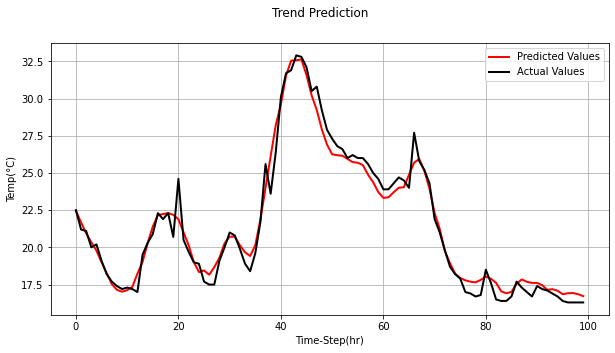

In [18]:
#---------------------------------------------------------------#
# 추가: model5 추가

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2

train_predictions = model5.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test})
# display(train_results)

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_2hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

    for label_col in train_results.columns:
        label = np.array(train_results[label_col])
        result_array = reverse_minmax(label, min_, max_)
        train_results[label_col + '_original_values'] = result_array
display(train_results)

plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")
plt.plot(train_results['Test Predictions_original_values'][:100], 'r', label='Predicted Values')
plt.plot(train_results['Actuals_original_values'][:100], 'k', label='Actual Values')
plt.legend()
plt.suptitle("Trend Prediction")
#---------------------------------------------------------------#

predicted_future_point:  22.44785085916519
true_future_point:  21.100000000000005
history_values:  [24.7 24.9 24.8 23.9]



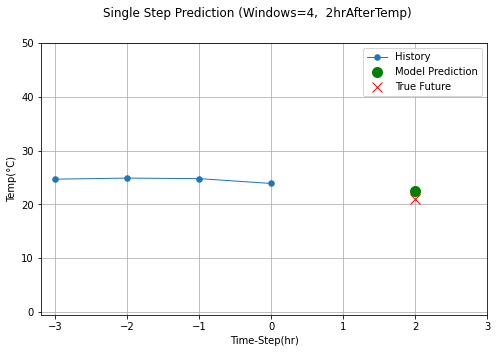

In [19]:
# 변경 Single Point Graph 코드 추가

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


future_time_step = 2
predicted_future_point = model5.predict(X_test).flatten()[0]
# y_train도 2시간 뒤에 값이므로 y_test도 2시간 뒤 값으로 맞춰주기
true_future_point = y_test[0 + future_time_step]

history_values = X_test[0][:, 8]    # X_test의 9 번째 열 (Temp_2hrAfter(°C))에 대한 4 times window 만들기   
history_time_steps = list(range(-len(history_values)+1, 1))

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_2hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

# min-max scaling된 값을 원래값으로 되돌리기
predicted_future_point = predicted_future_point * (max_ - min_) + min_
true_future_point = true_future_point * (max_ - min_) + min_
history_values = list(map(lambda x: (x * (max_ - min_) + min_), history_values))
history_values = np.array(history_values)

print("predicted_future_point: ", predicted_future_point)
print("true_future_point: ", true_future_point)
print("history_values: ", history_values)
print()

labels = ["History", "True Future", "Model Prediction"]
marker = [".-", "rx", "go"]

plt.xlim([-3.2, 3])
plt.ylim([-0.5, 50])
plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")

# 과거 기온 값 (windows=4)
plt.plot(history_time_steps, history_values, marker[0], markersize=11, label=labels[0])
# 학습된 모델로 예측된 2시간후 기온
plt.plot(future_time_step, predicted_future_point, marker[2], markersize=10, label=labels[2])
# 실제 기온
plt.plot(future_time_step, true_future_point, marker[1], markersize=10, label=labels[1]) 

plt.legend()
plt.suptitle("Single Step Prediction (Windows=4,  2hrAfterTemp)")
plt.show()
